In [1]:
from qiskit_dynamics import Solver, DynamicsBackend
from qiskit_dynamics.backend import default_experiment_result_function
from qiskit_dynamics.array import Array
import jax
from qiskit.providers.fake_provider import *
from qiskit import pulse

/home/riccardo/.venv/lib/python3.10/site-packages/qiskit_dynamics/dispatch/backends/jax.py:34: UserWarning: The functionality in the perturbation module of Qiskit Dynamics requires a JAX version <= 0.4.6, due to a bug in JAX versions > 0.4.6. For versions 0.4.4, 0.4.5, and 0.4.6, using the perturbation module functionality requires setting os.environ['JAX_JIT_PJIT_API_MERGE'] = '0' before importing JAX or Dynamics.
  warnings.warn(


In [2]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
import numpy as np
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.drivers import PySCFDriver

#gate_backend = provider.get_backend('simulator_statevector')

gate_backend =FakeManila()
gate_backend.configuration().hamiltonian['qub'] = {'0': 2,'1': 2,'2': 2,'3': 2,'4': 2}
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")
Array.set_default_backend("jax")
pulse_backend = DynamicsBackend.from_backend(gate_backend, evaluation_mode="sparse")
solver_options = {"method": "jax_odeint", "atol": 1e-6, "rtol": 1e-8}
pulse_backend.set_options(solver_options=solver_options)
pulse_backend.configuration = lambda: gate_backend.configuration()

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [ ]:
import numpy as np

dim = 3

v0 = 4.86e9
anharm0 = -0.32e9
r0 = 0.22e9

v1 = 4.97e9
anharm1 = -0.32e9
r1 = 0.26e9

J = 0.002e9

a = np.diag(np.sqrt(np.arange(1, dim)), 1)
adag = np.diag(np.sqrt(np.arange(1, dim)), -1)
N = np.diag(np.arange(dim))

ident = np.eye(dim, dtype=complex)
full_ident = np.eye(dim**2, dtype=complex)

N0 = np.kron(ident, N)
N1 = np.kron(N, ident)

a0 = np.kron(ident, a)
a1 = np.kron(a, ident)

a0dag = np.kron(ident, adag)
a1dag = np.kron(adag, ident)


static_ham0 = 2 * np.pi * v0 * N0 + np.pi * anharm0 * N0 * (N0 - full_ident)
static_ham1 = 2 * np.pi * v1 * N1 + np.pi * anharm1 * N1 * (N1 - full_ident)

static_ham_full = static_ham0 + static_ham1 + 2 * np.pi * J * ((a0 + a0dag) @ (a1 + a1dag))

drive_op0 = 2 * np.pi * r0 * (a0 + a0dag)
drive_op1 = 2 * np.pi * r1 * (a1 + a1dag)

In [ ]:
from qiskit_dynamics import Solver

# build solver
dt = 1/4.5e9

solver = Solver(
    static_hamiltonian=static_ham_full,
    hamiltonian_operators=[drive_op0, drive_op1, drive_op0, drive_op1],
    rotating_frame=static_ham_full,
    hamiltonian_channels=["d0", "d1", "u0", "u1"],
    channel_carrier_freqs={"d0": v0, "d1": v1, "u0": v1, "u1": v0},
    dt=dt,
)

In [ ]:
from qiskit_dynamics import DynamicsBackend

# Consistent solver option to use throughout notebook
solver_options = {"method": "jax_odeint", "atol": 1e-6, "rtol": 1e-8, "hmax": dt}

pulse_backend = DynamicsBackend(
    solver=solver,
    subsystem_dims=[dim, dim], # for computing measurement data
    solver_options=solver_options, # to be used every time run is called
)

In [3]:
import qiskit_nature
qiskit_nature.settings.use_pauli_sum_op = False  # pylint: disable=undefined-variable

In [4]:
from qiskit_nature.second_q.transformers import FreezeCoreTransformer,ActiveSpaceTransformer
import re
my_dict = {}

def get_qubit_op(dist):
    # Define Molecule
    ultra_simplified_ala_string = f"""
    H 0.0 0.0 0.0
    H 0.0 0.0 {dist}
    """
    
    driver = PySCFDriver(
        atom=ultra_simplified_ala_string.strip(),
        basis='sto3g',
        unit=DistanceUnit.ANGSTROM
    )
    qmolecule = driver.run()
    '''
    problem = FreezeCoreTransformer(
        freeze_core=True, remove_orbitals=[-3, -2]
    ).transform(qmolecule)

    num_particles = problem.num_particles
    num_spatial_orbitals = problem.num_spatial_orbitals

    mapper = ParityMapper(num_particles=num_particles)
    qubit_op = mapper.map(problem.second_q_ops()[0])
    #print(qubit_op)'''
    num_active_electrons = 2
    num_active_orbitals = 2
    as_transformer = ActiveSpaceTransformer(num_active_electrons,num_active_orbitals)
    problem = as_transformer.transform(qmolecule)
    mapper = ParityMapper(num_particles = problem.num_particles)
    qubit_op = mapper.map(problem.second_q_ops()[0])
    
    for pauli in qubit_op:
        #print(pauli)
        str_info = pauli.__str__()
        #print(f"Rappresentazione della stringa: {str_info}")
    
        # Estrai i coefficienti
        coeffs_start = str_info.find("coeffs=[") + len("coeffs=[")
        coeffs_end = str_info.find("]", coeffs_start)
        coeffs_str_complex = complex(str_info[coeffs_start:coeffs_end].strip())
        coeffs_str = coeffs_str_complex.real
        #print(coeffs_str)
        
        # Estrai gli operatori come stringa
        operators_start = str_info.find("[") + len("[")
        operators_end = str_info.find("])", operators_start)
        operators_str = str_info[operators_start:operators_end].strip()
        label_start = operators_str.find("'") + 1
        label_end = operators_str.find("'", label_start)
        label = operators_str[label_start:label_end]
        #print(label)
    
        '''# Utilizza espressioni regolari per estrarre la parte reale e immaginaria dei coefficienti
        coeffs_match = re.findall(r"(-?\d+\.\d+)([+-]\d+\.\d+j)?", coeffs_str)
    
        # Inizializza i coefficienti come float
        real_coeffs = [float(match[0]) for match in coeffs_match]
        imag_coeffs = [float(match[1]) if match[1] else 0.0 for match in coeffs_match]
    
        # Somma i coefficienti complessi
        complex_coeff = sum(complex(real, imag) for real, imag in zip(real_coeffs, imag_coeffs))'''
    
        # Aggiungi il coefficiente all'operatore nel dizionario
        #current_coeff = my_dict.get(operators_str, 0.0)
        #my_dict[operators_str] = coeffs_str
        my_dict[label] = coeffs_str
        
        
    return qubit_op, my_dict,problem

In [5]:
from qiskit_nature import settings
settings.use_pauli_sum_op = False

In [6]:
from qiskit.pulse import Schedule, GaussianSquare, Drag, Delay, Play, ControlChannel, DriveChannel

def drag_pulse(backend, amp, angle):
  backend_defaults = backend.defaults()
  inst_sched_map = backend_defaults.instruction_schedule_map
  x_pulse = inst_sched_map.get('x', (0)).filter(channels = [DriveChannel(0)], instruction_types=[Play]).instructions[0][1].pulse
  duration_parameter = x_pulse.parameters['duration']
  sigma_parameter = x_pulse.parameters['sigma']
  beta_parameter = x_pulse.parameters['beta']
  pulse1 = Drag(duration=duration_parameter, sigma=sigma_parameter, beta=beta_parameter, amp=amp, angle=angle)
  return pulse1

In [7]:
def cr_pulse(backend, amp, angle, duration):
  backend_defaults = backend.defaults()
  inst_sched_map = backend_defaults.instruction_schedule_map
  cr_pulse = inst_sched_map.get('cx', (0, 1)).filter(channels = [ControlChannel(0)], instruction_types=[Play]).instructions[0][1].pulse
  cr_params = {}
  cr_params['duration'] = cr_pulse.parameters['duration']
  cr_params['amp'] = cr_pulse.parameters['amp']
  cr_params['angle'] = cr_pulse.parameters['angle']
  cr_params['sigma'] = cr_pulse.parameters['sigma']
  cr_params['width'] = cr_pulse.parameters['width']
  cr_risefall = (cr_params['duration'] - cr_params['width']) / (2 * cr_params['sigma'])
  angle_parameter = angle
  duration_parameter =  duration
  sigma_parameter = cr_pulse.parameters['sigma']
  width_parameter = int(duration_parameter - 2 * cr_risefall * cr_params['sigma'])
  #declare pulse parameters and build GaussianSquare pulse
  pulse1 = GaussianSquare(duration = duration_parameter, amp = amp, angle = angle_parameter, sigma = sigma_parameter, width=width_parameter)
  return pulse1

In [8]:
'''def HE_pulse(backend, amp, angle, width):
    with pulse.build(backend) as my_program1:
      # layer 1
      sched_list = []
      with pulse.build(backend) as sched1:
          qubits = (0,1,2,3)
          for i in range(4):
              pulse.play(drag_pulse(backend, amp[i], angle[i]), DriveChannel(qubits[i]))
      sched_list.append(sched1)

      with pulse.build(backend) as sched2:
          uchan = pulse.control_channels(0, 1)[0]
          pulse.play(cr_pulse(backend,amp[4], angle[4], width[0]), uchan)
      sched_list.append(sched2)


      with pulse.build(backend) as sched4:
          uchan = pulse.control_channels(1, 2)[0]
          pulse.play(cr_pulse(backend, amp[5], angle[5], width[1]), uchan)
      sched_list.append(sched4)

      with pulse.build(backend) as sched6:
          uchan = pulse.control_channels(2,3)[0]
          pulse.play(cr_pulse(backend, amp[6],angle[6], width[2]), uchan)
      sched_list.append(sched6)


      with pulse.build(backend) as my_program:
        with pulse.transpiler_settings(initial_layout= [0,1,2,3]):
          with pulse.align_sequential():
              for sched in sched_list:
                  pulse.call(sched)

    return my_program'''
def HE_pulse(backend, amp, angle, width):
    with pulse.build(backend) as my_program1:
        # layer 1
        sched_list = []
        with pulse.build(backend) as sched1:
            qubits = (0, 1)
            for i in range(2):
                pulse.play(drag_pulse(backend, amp[i], angle[i]), DriveChannel(qubits[i]))
        sched_list.append(sched1)

        with pulse.build(backend) as sched2:
            uchan = pulse.control_channels(0, 1)[0]
            pulse.play(cr_pulse(backend, amp[0], angle[2], width[0]), uchan)
        sched_list.append(sched2)

        with pulse.build(backend) as sched4:
            uchan = pulse.control_channels(0, 1)[0]
            pulse.play(cr_pulse(backend, amp[1], angle[3], width[0]), uchan)
        sched_list.append(sched4)

        with pulse.build(backend) as my_program:
            with pulse.transpiler_settings(initial_layout=[0, 1]):
                with pulse.align_sequential():
                    for sched in sched_list:
                        pulse.call(sched)

    return my_program


In [9]:
import copy
from scipy.optimize import minimize, LinearConstraint

def measurement_pauli(prepulse, pauli_string, backend, n_qubit):
    with pulse.build(backend) as pulse_measure:
        pulse.call(copy.deepcopy(prepulse))
        for ind,pauli in enumerate(pauli_string):
            if(pauli=='X'):
                pulse.u2(0, np.pi, ind)
            if(pauli=='Y'):
                pulse.u2(0, np.pi/2, ind)
        for qubit in range(n_qubit):
            pulse.barrier(qubit)
        pulse.measure(range(n_qubit))
    return pulse_measure

def n_one(bitstring, key):
    results = 0
    for ind,b in enumerate(reversed(bitstring)):
        if((b=='1')&(key[ind]!='I')):
            results+=1
    return results

def expectation_value(counts,shots,key):
    results = 0
    for bitstring in counts:
        if(n_one(bitstring, key)%2==1):
            results -= counts[bitstring]/shots
        else:
            results += counts[bitstring]/shots
    return results

def run_pulse_sim(meas_pulse, key, pulse_backend, backend, n_shot):
    results = pulse_backend.run(meas_pulse).result()
    counts = results.get_counts()
    expectation = expectation_value(counts,n_shot,key)
    return expectation

def gen_LC_vqe(parameters):
    lb = np.zeros(parameters)
    ub = np.ones(parameters)
    LC = (LinearConstraint(np.eye(parameters),lb,ub,keep_feasible=False))
    return LC

In [10]:
def vqe_one(prepulse,n_qubit,n_shot,pulse_backend, backend,key,value):
    all_Is = True
    for key_ele in key:
        if(key_ele!='I'):
            all_Is = False
    if(all_Is):
        return value
    meas_pulse = measurement_pauli(prepulse=prepulse, pauli_string=key, backend=backend, n_qubit=n_qubit)
    return value*run_pulse_sim(meas_pulse, key, pulse_backend, backend, n_shot)

In [11]:
def vqe(params,pauli_dict,pulse_backend, backend,n_qubit,n_shot):
    #print("params in def chemistry in vqe.py: ", params)
    # assert(len(params)%2==0)
    width_len = int(len(params)-1*(n_qubit-1))
    split_ind = int(width_len/3)
    amp = np.array(params[:split_ind])
    angle = np.array(params[split_ind:width_len])*np.pi*2
    width_1 = (np.array(params[width_len:]))
    num_items = (1024 - 256) // 16 + 1
    width_norm = (width_1 - 256) / (1024 - 256)
    width_norm = np.clip(width_norm, 0, 1)
    width = (np.round(width_norm * (num_items - 1)) * 16 + 256).astype(int) 
    amp = amp.tolist()
    angle = angle.tolist()
    width = width.tolist()
    keys = [key for key in pauli_dict]
    values = [pauli_dict[key] for key in pauli_dict]
    expect_values = []

    for key, value in zip(keys, values):
        prepulse = HE_pulse(backend, amp, angle, width)
        expect = vqe_one(prepulse, n_qubit, n_shot, pulse_backend, backend, key, value)
        expect_values.append(expect)
    #print("E for cur_iter: ",sum(expect_values))
    return sum(expect_values)

In [12]:
from qiskit.algorithms.optimizers import SPSA, SLSQP, COBYLA
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit_aer.primitives import Estimator

def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result

distances = np.arange(0.2, 2.0, 0.1)
exact_energies = []
pvqe_energies_1 = []
iterazioni = []
errore = []

n_qubit = 2
parameters = 7
np.random.seed(99999999)
LC = gen_LC_vqe(parameters)
#params = np.zeros(parameters)
params = [0.0, 0. , 0.,  0. , 0. , 0. , 0.,]

n_shot = 2048
optimizer = 'COBYLA'
noiseless_estimator = Estimator(approximation=True)

for dist in distances:
    #params = np.zeros(parameters)
    #params = np.random.rand(parameters)
    (qubit_op,my_dict,problem) = get_qubit_op(dist)
    result = exact_solver(qubit_op, problem)
    exact_energies.append(result.total_energies[0].real)
    #print('distanza:', dist)
    vqe_res = minimize(vqe, params, args=(my_dict, pulse_backend, gate_backend, n_qubit, n_shot),
                       method=optimizer, constraints=LC,options={'rhobeg':0.1,'maxiter':0})
    #print('The optimized loss func value: {}'.format(vqe_res.fun))
    pvqe_energies_1.append(vqe_res.fun)
    err = abs(12/100 * vqe_res.fun)
    errore.append(err)
    print('distanza:',dist)
    print('pulse_VQE:',vqe_res.fun,'+/-',err)
    print('esatto:',result.total_energies[0].real)
    #print(my_dict)

pvqe_energies_2 = []
params = [0.1, 0.0 , 0.,  0. , 0. , 0. , 0.,]
for dist in distances:
    #params = np.zeros(parameters)
    #params = np.random.rand(parameters)
    (qubit_op,my_dict,problem) = get_qubit_op(dist)
    result = exact_solver(qubit_op, problem)
    #exact_energies.append(result.total_energies[0].real)
    #print('distanza:', dist)
    vqe_res = minimize(vqe, params, args=(my_dict, pulse_backend, gate_backend, n_qubit, n_shot),
                       method=optimizer, constraints=LC,options={'rhobeg':0.1,'maxiter':0})
    #print('The optimized loss func value: {}'.format(vqe_res.fun))
    pvqe_energies_2.append(vqe_res.fun)
    err = abs(12/100 * vqe_res.fun)
    errore.append(err)
    print('distanza:',dist)
    print('pulse_VQE:',vqe_res.fun,'+/-',err)
    print('esatto:',result.total_energies[0].real)
    #print(my_dict)

pvqe_energies_3 = []
params = [ 5.77602736e-02,  1.29297911e-01,  1.76817691e-17, -3.46944695e-18,
  1.28949827e-01,  0.00000000e+00,  0.00000000e+00]
for dist in distances:
    #params = np.zeros(parameters)
    #params = np.random.rand(parameters)
    (qubit_op,my_dict,problem) = get_qubit_op(dist)
    result = exact_solver(qubit_op, problem)
    #exact_energies.append(result.total_energies[0].real)
    #print('distanza:', dist)
    vqe_res = minimize(vqe, params, args=(my_dict, pulse_backend, gate_backend, n_qubit, n_shot),
                       method=optimizer, constraints=LC,options={'rhobeg':0.1,'maxiter':0})
    #print('The optimized loss func value: {}'.format(vqe_res.fun))
    pvqe_energies_3.append(vqe_res.fun)
    err = abs(12/100 * vqe_res.fun)
    errore.append(err)
    print('distanza:',dist)
    print('pulse_VQE:',vqe_res.fun,'+/-',err)
    print('esatto:',result.total_energies[0].real)

pvqe_energies_4 = []
params = [ 8.673617E-20,   1.219578E-01,   1.902411E-17,   3.749686E-02,   1.599968E-01,
       0.000000E+00,   0.000000E+00]
for dist in distances:
    #params = np.zeros(parameters)
    #params = np.random.rand(parameters)
    (qubit_op,my_dict,problem) = get_qubit_op(dist)
    result = exact_solver(qubit_op, problem)
    #exact_energies.append(result.total_energies[0].real)
    #print('distanza:', dist)
    vqe_res = minimize(vqe, params, args=(my_dict, pulse_backend, gate_backend, n_qubit, n_shot),
                       method=optimizer, constraints=LC,options={'rhobeg':0.1,'maxiter':0})
    #print('The optimized loss func value: {}'.format(vqe_res.fun))
    pvqe_energies_4.append(vqe_res.fun)
    err = abs(12/100 * vqe_res.fun)
    errore.append(err)
    print('distanza:',dist)
    print('pulse_VQE:',vqe_res.fun,'+/-',err)
    print('esatto:',result.total_energies[0].real)

/tmp/ipykernel_56668/2345946684.py:1: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import SPSA, SLSQP, COBYLA
/home/riccardo/.venv/lib/python3.10/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


distanza: 0.2
pulse_VQE: -0.56218343 +/- 0.0674620116
esatto: 0.15748213479836437
distanza: 0.30000000000000004
pulse_VQE: -0.67997668 +/- 0.0815972016
esatto: -0.6018037107656868
distanza: 0.4000000000000001
pulse_VQE: -0.7867788050000001 +/- 0.0944134566
esatto: -0.9141497046270819
distanza: 0.5000000000000001
pulse_VQE: -0.8695309799999998 +/- 0.10434371759999998
esatto: -1.0551597944706232
distanza: 0.6000000000000001
pulse_VQE: -0.926293955 +/- 0.11115527459999999
esatto: -1.1162860068695402
distanza: 0.7000000000000002
pulse_VQE: -0.96016593 +/- 0.11521991159999999
esatto: -1.1361894540659203
distanza: 0.8000000000000003
pulse_VQE: -0.9763042750000002 +/- 0.11715651300000002
esatto: -1.1341476666770962
distanza: 0.9000000000000001
pulse_VQE: -0.97998198 +/- 0.1175978376
esatto: -1.1205602812999877
distanza: 1.0000000000000002
pulse_VQE: -0.9753556650000001 +/- 0.11704267980000001
esatto: -1.1011503302326187
distanza: 1.1000000000000003
pulse_VQE: -0.965198965 +/- 0.1158238758
esa

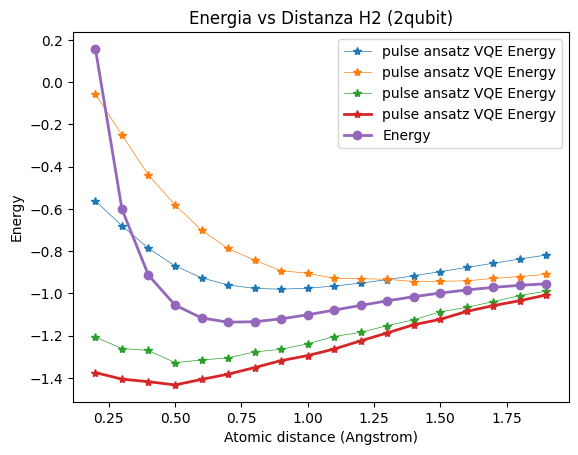

In [14]:
import matplotlib.pyplot as plt
plt.plot(distances, pvqe_energies_1, marker = "*", linewidth=0.5, label="pulse ansatz VQE Energy")
plt.plot(distances, pvqe_energies_2, marker = "*", linewidth=0.5, label="pulse ansatz VQE Energy")
plt.plot(distances, pvqe_energies_3, marker = "*", linewidth=0.5, label="pulse ansatz VQE Energy")
plt.plot(distances, pvqe_energies_4, marker = "*", linewidth=2.0, label="pulse ansatz VQE Energy")
plt.plot(distances, exact_energies, marker = "o", linewidth=2.0, label="Energy")
plt.xlabel("Atomic distance (Angstrom)")
plt.ylabel("Energy")
plt.legend()
plt.title('Energia vs Distanza H2 (2qubit)')
output_path = 'EnergyVSdistH2(2qubit).png'
plt.savefig(output_path)
plt.show()